In [1]:
import numpy as np
import mne
import matplotlib
matplotlib.use('Qt5Agg')      #pop  figure out of  line.....
mne.set_log_level('warning')  #only shows warnings..

In [2]:
class BCICompetition4Set2B(object):
    
    def __init__(self, filename, load_sensor_names=None, labels_filename=None, feedback=True):
       
        assert load_sensor_names is None
        self.__dict__.update(locals())
        del self.self
    
    
    def load(self):                            #main code
        cnt = self.extract_data()               #load file replace nan with nanmean, return file with events...
        events, artifact_trial_mask = self.extract_events(cnt)   
        cnt.info["events"] = events            #event  converted in Class1=left, Class2=right
        cnt.info["artifact_trial_mask"] = artifact_trial_mask  #get loccation of rejected  trails 
        cnt.info["events_id"]  = {'Left': 1,'Right': 2,}
        return cnt
    
    def extract_data(self):
        
        raw_gdf = mne.io.read_raw_gdf(self.filename, stim_channel="auto")
        raw_gdf.load_data()
        data = raw_gdf.get_data()

        for i_chan in range(data.shape[0]):
            # first set to nan, than replace nans by nanmean.
            this_chan = data[i_chan]
            data[i_chan] = np.where(
                this_chan == np.min(this_chan), np.nan, this_chan
            )
            mask = np.isnan(data[i_chan])
            chan_mean = np.nanmean(data[i_chan])
            data[i_chan, mask] = chan_mean

        
        gdf_events = mne.events_from_annotations(raw_gdf)
        raw_gdf = mne.io.RawArray(data, raw_gdf.info, verbose="WARNING")
      
        raw_gdf.info["gdf_events"] = gdf_events
        return raw_gdf

    def extract_events(self, raw_gdf):
       
        
        events, name_to_code = raw_gdf.info["gdf_events"]

    
        if not ("783" in name_to_code): #checking for cue unkown
            train_set = True
        else:
            train_set = False
            
       
        if train_set:
            trial_codes = [name_to_code['769'],name_to_code['770']]  # the classes                
        else:
            trial_codes = [name_to_code['783']]  # Que unkown for  test cases.

        
        trial_mask = [ev_code in trial_codes for ev_code in events[:, 2]]
        trial_events = events[trial_mask]
        print("Got {:d} markers".format(len(trial_events)))
       
        #change the position of  the classes  to   1  and  2.
        trial_events[:, 2] = trial_events[:, 2] - name_to_code['768']   
        
        # now also create 0-1 vector for rejected trials
            
        trial_start_events = events[events[:, 2] == name_to_code['768']]
        assert len(trial_start_events) == len(trial_events)
        artifact_trial_mask = np.zeros(len(trial_events), dtype=np.uint8)
        artifact_events = events[events[:, 2] == 1]
        
        for artifact_time in artifact_events[:, 0]:
            i_trial = trial_start_events[:, 0].tolist().index(artifact_time)
            artifact_trial_mask[i_trial] = 1

        return trial_events, artifact_trial_mask

In [3]:
fname = 'b0101T.gdf'
moeed1  =  BCICompetition4Set2B(fname)
moeed=  moeed1.load()

C:\Users\adm\anaconda3\envs\envpytorch\lib\site-packages\mne\io\edf\edf.py:1044: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
<ipython-input-2-f1b2731024da>:20: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw_gdf = mne.io.read_raw_gdf(self.filename, stim_channel="auto")


Got 120 markers


In [18]:
print(moeed) #6chanel, 604803 frequency value, (604803/sfreq=250)=2419.2s time 
print(moeed.info)

<RawArray | 6 x 604803 (2419.2 s), ~27.7 MB, data loaded>
<Info | 11 non-empty values
 artifact_trial_mask: 120 items (ndarray)
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
 chs: 6 EEG
 custom_ref_applied: False
 events: 120 items (ndarray)
 events_id: 2 items (dict)
 gdf_events: 2 items (tuple)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2005-10-25 09:35:11 UTC
 nchan: 6
 projs: []
 sfreq: 250.0 Hz
>


In [14]:
moeed.plot(events=moeed.info['events'], event_id=moeed.info['events_id']) 

<MNEBrowseFigure size 1440x836 with 4 Axes>

In [17]:
moeed_crop= moeed.copy().drop_channels(['EOG:ch01', 'EOG:ch02', 'EOG:ch03'])
print(moeed_crop)
print(moeed_crop.info)

<RawArray | 3 x 604803 (2419.2 s), ~13.9 MB, data loaded>
<Info | 11 non-empty values
 artifact_trial_mask: 120 items (ndarray)
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4
 chs: 3 EEG
 custom_ref_applied: False
 events: 120 items (ndarray)
 events_id: 2 items (dict)
 gdf_events: 2 items (tuple)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2005-10-25 09:35:11 UTC
 nchan: 3
 projs: []
 sfreq: 250.0 Hz
>


In [99]:
fitered_crop  = moeed_crop.copy().filter(l_freq=8, h_freq=40)
print(fitered_crop)
print(fitered_crop.info)

<RawArray | 3 x 604803 (2419.2 s), ~13.9 MB, data loaded>
<Info | 11 non-empty values
 artifact_trial_mask: 120 items (ndarray)
 bads: []
 ch_names: EEG:C3, EEG:Cz, EEG:C4
 chs: 3 EEG
 custom_ref_applied: False
 events: 120 items (ndarray)
 events_id: 2 items (dict)
 gdf_events: 2 items (tuple)
 highpass: 8.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2005-10-25 09:35:11 UTC
 nchan: 3
 projs: []
 sfreq: 250.0 Hz
>


In [20]:
mne.viz.plot_events(moeed_crop.info["events"], event_id=moeed_crop.info["events_id"], sfreq=moeed.info['sfreq'])

<Figure size 1440x803 with 1 Axes>

In [118]:
tmin = -0.3
tmax = 1.5
baseline = (None, 0)

epochs = mne.Epochs(fitered_crop,
                    events=moeed_crop.info["events"],
                    event_id=moeed_crop.info["events_id"],
                    tmin=tmin,
                    tmax=tmax,
                    baseline=baseline,
                    preload=True)
epochs

<Epochs |  120 events (all good), -0.3 - 1.5 sec, baseline [-0.3, 0] sec, ~1.3 MB, data loaded,
 'Left': 60
 'Right': 60>

In [101]:
epochs.plot_psd()

<ipython-input-101-697022bd73f1>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


<MNELineFigure size 1000x350 with 1 Axes>

In [75]:
epochs['Left'].plot_image()

[<Figure size 640x480 with 3 Axes>]

In [26]:
evoked_left = epochs['Left'].average()
evoked_Right = epochs['Right'].average()

In [30]:
evoked_left.plot(spatial_colors=True)
evoked_Right.plot(spatial_colors=True)

<ipython-input-30-6cc7adf0c6ac>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  evoked_left.plot(spatial_colors=True)
<ipython-input-30-6cc7adf0c6ac>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  evoked_Right.plot(spatial_colors=True)


<Figure size 640x300 with 1 Axes>

In [31]:
mne.viz.plot_compare_evokeds([evoked_left, evoked_Right])

[<Figure size 800x600 with 1 Axes>]

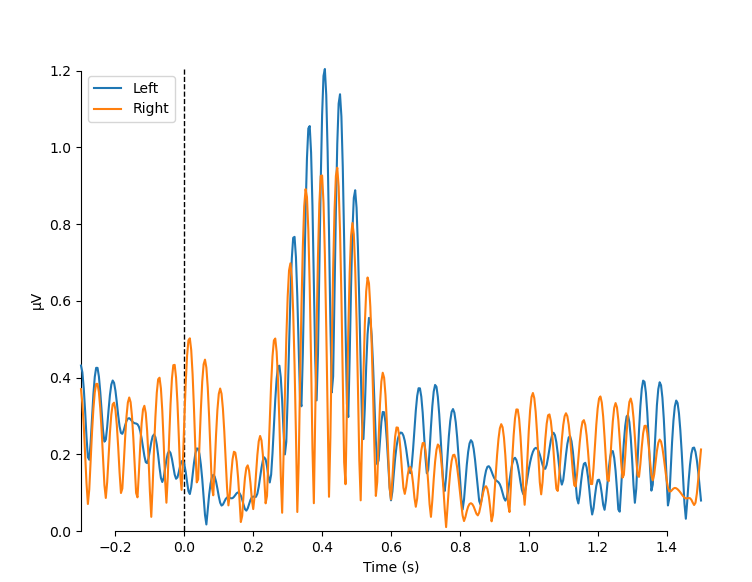

In [88]:
reject_criteria = dict(eeg=150e-6,)       # 150 µV
                      

flat_criteria = dict(eeg=1e-6) 
epochs.drop_bad(reject=reject_criteria, flat=flat_criteria)
evoked_left_ssp = epochs['Left'].average()
evoked_Right_ssp = epochs['Right'].average()

In [33]:
mne.viz.plot_compare_evokeds([evoked_left_ssp, evoked_Right_ssp])

[<Figure size 800x600 with 1 Axes>]

In [89]:
epochs.selection

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119], dtype=int64)

In [90]:
events=moeed_crop.info["events"][epochs.selection]

In [41]:
moeed_crop.info["events"].shape


(120, 3)

In [110]:
tmin = -0.3
tmax = 0.5
baseline = (None, 0)

epochs_ica = mne.Epochs(fitered_crop,
                        events=moeed_crop.info["events"],
                        event_id=moeed_crop.info["events_id"],
                        tmin=tmin,
                        tmax=tmax,
                        baseline=baseline,
                        preload=True)

In [112]:
n_components = 0.9 # Should normally be higher, like 0.999!!
max_iter = 500  # Should normally be higher, like 500 or even 1000!!
random_state = 42

ica = mne.preprocessing.ICA(n_components=n_components,
                         
                            method='fastica',
                            max_iter=max_iter,
                          
                            random_state=random_state)
ica.fit(epochs_ica)

<ICA | epochs decomposition, fit (fastica): 24120 samples, 3 components, channels used: "eeg">

In [114]:

ica.plot_sources(epochs_ica)


<MNEBrowseFigure size 1440x836 with 4 Axes>

In [120]:
epochs_clean = ica.apply(epochs.copy())
epochs_clean

<Epochs |  120 events (all good), -0.3 - 1.5 sec, baseline [-0.3, 0] sec, ~1.3 MB, data loaded,
 'Left': 60
 'Right': 60>

In [122]:
epochs_clean.plot(events=moeed_crop.info["events"],
                        event_id=moeed_crop.info["events_id"],)

<MNEBrowseFigure size 1440x836 with 4 Axes>